In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import expit

import statsmodels.formula.api as smf
import statsmodels.api as sm


%matplotlib inline


In [39]:
# define confounders
c = np.random.binomial(1, .5, 2000)
c2 = np.random.normal(size=2000)

# define treatment
p = np.exp(.7*c - .1*c2)/(1 + np.exp(.7*c - .1*c2))
trt = np.random.binomial(1, p, 2000)

# outcome
y = .1*trt - .5*c - .2*c2 + np.random.normal(0, .5, 2000)

data = pd.DataFrame({'y': y, 'trt':trt, 'c2': c2, 'c':c})
data.head()

,y,trt,c2,c
0,-0.745213,0,1.009673,0
1,-0.770460,1,0.568863,1
2,-0.127567,1,-0.717571,1
3,0.201624,0,-1.154207,1
4,0.136969,0,-0.945644,0


## Unadjusted Effects

In [40]:
res = smf.glm('y ~ trt', data).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 2000
Model:                            GLM   Df Residuals:                     1998
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                         0.33320
Method:                          IRLS   Log-Likelihood:                -1737.9
Date:                Tue, 26 Jan 2021   Deviance:                       665.73
Time:                        09:11:02   Pearson chi2:                     666.
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2122      0.020    -10.551      0.000      -0.252      -0.173
trt            0.0555      0.026      2.117      0.034       0.004       0.107
==============================================================================
"""

## Regression Adjustment

In [52]:
res = smf.glm('y ~ trt + c + c2', data).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 2000
Model:                            GLM   Df Residuals:                     1996
Model Family:                Gaussian   Df Model:                            3
Link Function:               identity   Scale:                         0.24343
Method:                          IRLS   Log-Likelihood:                -1423.0
Date:                Wed, 27 Jan 2021   Deviance:                       485.89
Time:                        07:00:01   Pearson chi2:                     486.
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0302      0.019     -1.562      0.118      -0.068       0.008
trt            0.1155      0.023      5.067      0.000       0.071       0.160
c             -0.4490      0.022    -20.026      0.000      -0.493      -0.405
c2            -0.2003      0.011    -18.011      0.000      -0.222      -0.179
==============================================================================
"""

## Propensity Scores

In [79]:
ps_model = smf.glm('trt ~ c + c2', data, family=sm.families.Binomial()).fit()
ps = ps_model.predict(data)
trt_mask = data.trt==1

# raw propensity scores
iptw = 1/ps
iptw[~trt_mask] = 1/(1-ps[~trt_mask])

# stabalize propensity scores
avg_trt = np.mean(data['trt'])

stable_iptw = avg_trt/ps
stable_iptw[~trt_mask] = (1-avg_trt)/(1-ps[~trt_mask])

# truncated weights
trunc_iptw = np.copy(stable_iptw)
lb, ub = np.percentile(trunc_iptw, (5, 95))
trunc_iptw[trunc_iptw<lb] = lb
trunc_iptw[trunc_iptw>ub] = ub

Text(0.5, 1.0, 'Truncated IPTW')

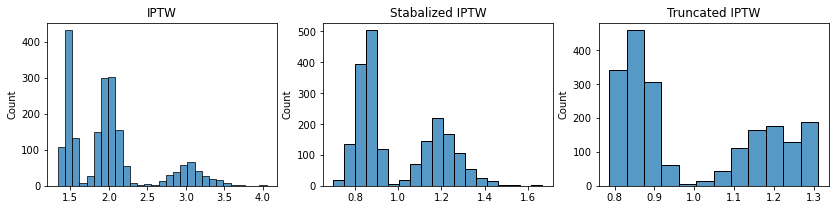

In [80]:
fig, axes = plt.subplots(1, 3, figsize=(14,3))
sns.histplot(iptw, ax=axes[0])
axes[0].set_title('IPTW')

sns.histplot(stable_iptw, ax=axes[1])
axes[1].set_title('Stabalized IPTW')

sns.histplot(trunc_iptw, ax=axes[2])
axes[2].set_title('Truncated IPTW')

### Weighted Outcome

In [82]:
res = smf.glm('y ~ trt', data, freq_weights=iptw).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 2000
Model:                            GLM   Df Residuals:                  3997.45
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                         0.33789
Method:                          IRLS   Log-Likelihood:                -3504.2
Date:                Thu, 28 Jan 2021   Deviance:                       1350.7
Time:                        07:23:46   Pearson chi2:                 1.35e+03
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2459      0.013    -18.913      0.000      -0.271      -0.220
trt            0.1145      0.018      6.228      0.000       0.078       0.151
==============================================================================
"""

In [86]:
res = smf.glm('trt ~ c + c2', data, freq_weights=iptw).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    trt   No. Observations:                 2000
Model:                            GLM   Df Residuals:                     1997
Model Family:                Gaussian   Df Model:                            2
Link Function:               identity   Scale:                         0.23440
Method:                          IRLS   Log-Likelihood:                -1385.6
Date:                Thu, 28 Jan 2021   Deviance:                       468.09
Time:                        08:52:28   Pearson chi2:                     468.
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4991      0.015     32.464      0.000       0.469       0.529
c              0.1742      0.022      8.047      0.000       0.132       0.217
c2            -0.0259      0.011     -2.374      0.018      -0.047      -0.005
==============================================================================
"""